# Examples reservoir models
*Mark Bakker, Delft University of Technology*

**Warning:** 
This is a proof-of-concept of the Reservoir model. The Reservoir model is still under development and not yet meant for general application. No noise model has been used in the models presented in this notebook. This might lead to wrong estimates of the parameter uncertainties.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
import pastas as ps
ps.show_versions()

Python version: 3.8.2 (default, Mar 25 2020, 11:22:43) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy version: 1.21.2
Scipy version: 1.7.1
Pandas version: 1.3.3
Pastas version: 0.19.0b
Matplotlib version: 3.4.3


## Single reservoir model as compared to exponential response function

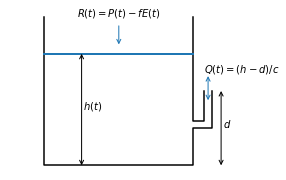

In [2]:
def arrow(xystart, xyend, text="", arrow="<-", color='k', **kwds):
    plt.annotate(text,
                 xy=xystart, 
                 xytext=xyend, 
                 arrowprops=dict(arrowstyle=arrow, shrinkA=0, shrinkB=0, color=color),
                 color=color,
                 **kwds)

plt.figure(figsize=(4, 5))
plt.subplot(111, aspect=1)
plt.plot([0.2, 0.2, 1, 1, 1.1, 1.1], [0.8, 0, 0, 0.2, 0.2, 0.4], 'k')
plt.plot([1.06, 1.06, 1, 1], [0.4, 0.24, 0.24, 0.8], 'k' )
plt.plot([0.2, 1], [0.6, 0.6], 'C0', lw=2)
arrow((1.08, 0.35), (1.08, 0.48), arrow='<->', color='C0')
plt.text(0.41, 0.3, '$h(t)$')
plt.text(1.06, 0.5, '$Q(t)=(h-d)/c$')
arrow((1.15, 0), (1.15, 0.4), arrow='<->')
plt.text(1.16, 0.2, '$d$')
arrow((0.6, 0.75), (0.6, 0.65), color='C0')
plt.text(0.6, 0.8, '$R(t)=P(t)-fE(t)$', ha='center')
arrow((0.4, 0), (0.4, 0.6), arrow='<->')
plt.xlim(0, 1.2)
plt.axis('off');

\begin{equation}
\frac{\text{d}h}{\text{d}t} = \frac{R}{S} - \frac{h-d}{cS}
\end{equation}

Implicit solution:
\begin{equation}
h_t = \frac{h_{t-\Delta t} + R\Delta t / S + \Delta t / (cS) d}{1 + \Delta t / (cS)}
\end{equation}

In [3]:
hobs = pd.read_csv('../data/head_nb1.csv', parse_dates=['date'],
                     index_col='date', squeeze=True)
prec = pd.read_csv('../data/rain_nb1.csv', parse_dates=['date'],
                     index_col='date', squeeze=True)
evap = pd.read_csv('../data/evap_nb1.csv', parse_dates=['date'],
                   index_col='date', squeeze=True)

In [4]:
ml = ps.Model(hobs, name="reservoirtest", constant=False, noisemodel=False)
rsv = ps.ReservoirModel([prec, evap], ps.reservoir.Reservoir1, 'reservoir', ml.oseries.series.mean())
ml.add_stressmodel(rsv)

INFO: Cannot determine frequency of series head: freq=None. The time series is irregular.
INFO: Inferred frequency for time series rain: freq=D
INFO: Inferred frequency for time series evap: freq=D


In [5]:
#%timeit ml.solve(noise=False, solver=ps.LmfitSolve, tmin='1995', tmax='2005', report=False)

In [6]:
ml.solve(noise=False, solver=ps.LmfitSolve, tmin='1995', tmax='2005')
hreservoir = ml.simulate()

Fit report reservoirtest           Fit Statistics
nfev    42                     EVP           93.26
nobs    196                    R2             0.93
noise   False                  RMSE           0.12
tmin    1995-01-01 00:00:00    AIC         -827.86
tmax    2005-01-01 00:00:00    BIC         -814.75
freq    D                      Obj            2.76
warmup  3650 days 00:00:00     ___                
solver  LmfitSolve             Interp.          No

Parameters (4 optimized)
                optimal  stderr     initial  vary
reservoir_S    0.215057  ±4.13%    0.100000  True
reservoir_c  658.040497  ±3.79%  100.000000  True
reservoir_d   27.716972  ±0.22%   27.900078  True
reservoir_f   -1.160523  ±4.62%   -1.000000  True


### Comparison with exponential response function
\begin{equation}
\theta_{step}=A(1-\text{e}^{-t/a})
\end{equation}
with
\begin{equation}
A = c
\end{equation}
\begin{equation}
a = cS
\end{equation}

In [7]:
mlbase = ps.Model(hobs)
sm = ps.RechargeModel(prec, evap, ps.Exponential, name='rech')
mlbase.add_stressmodel(sm)

INFO: Cannot determine frequency of series head: freq=None. The time series is irregular.
INFO: Inferred frequency for time series rain: freq=D
INFO: Inferred frequency for time series evap: freq=D


In [8]:
#%timeit mlbase.solve(solver=ps.LmfitSolve, noise=False, tmin='1995', tmax='2005', report=False)

In [9]:
mlbase.solve(solver=ps.LmfitSolve, noise=False, tmin='1995', tmax='2005')
hbase = mlbase.simulate()

Fit report head                   Fit Statistics
nfev    43                     EVP           93.27
nobs    196                    R2             0.93
noise   False                  RMSE           0.12
tmin    1995-01-01 00:00:00    AIC         -828.15
tmax    2005-01-01 00:00:00    BIC         -815.03
freq    D                      Obj            2.75
warmup  3650 days 00:00:00     ___                
solver  LmfitSolve             Interp.          No

Parameters (4 optimized)
               optimal  stderr     initial  vary
rech_A      657.567583  ±3.78%  215.674528  True
rech_a      140.853133  ±4.35%   10.000000  True
rech_f       -1.159280  ±4.61%   -1.000000  True
constant_d   27.715945  ±0.22%   27.900078  True


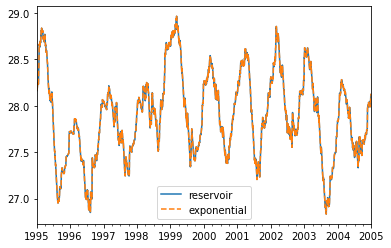

In [10]:
hreservoir.plot(label='reservoir')
hbase.plot(ls='--', label='exponential')
plt.legend();

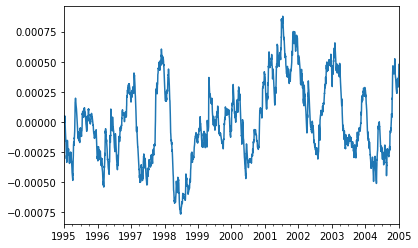

In [11]:
(hreservoir - hbase).plot();

## Reservoir model with overflow as compared to Tarso

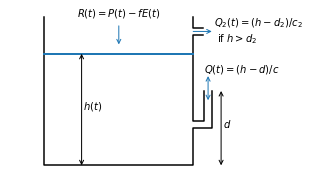

In [12]:
plt.figure(figsize=(4, 5))
plt.subplot(111, aspect=1)
plt.plot([0.2, 0.2, 1, 1, 1.1, 1.1], [0.8, 0, 0, 0.2, 0.2, 0.4], 'k')
plt.plot([1.06, 1.06, 1, 1, 1.05], [0.4, 0.24, 0.24, 0.7, 0.7], 'k' )
plt.plot([1.05, 1, 1], [0.74, 0.74, 0.8], 'k')
plt.plot([0.2, 1], [0.6, 0.6], 'C0', lw=2)
arrow((1.08, 0.35), (1.08, 0.48), arrow='<->', color='C0')
plt.text(0.41, 0.3, '$h(t)$')
plt.text(1.06, 0.5, '$Q(t)=(h-d)/c$')
arrow((1.15, 0), (1.15, 0.4), arrow='<->')
plt.text(1.16, 0.2, '$d$')
arrow((0.6, 0.75), (0.6, 0.65), color='C0')
plt.text(0.6, 0.8, '$R(t)=P(t)-fE(t)$', ha='center')
arrow((0.4, 0), (0.4, 0.6), arrow='<->')
arrow((1, 0.72), (1.1, 0.72), color='C0')
plt.text(1.11, 0.72, '$Q_2(t)=(h-d_2)/c_2$ \n if $h>d_2$', va='center')
plt.xlim(0, 1.2)
plt.axis('off');

\begin{equation}
\frac{\text{d}h}{\text{d}t} = \frac{R}{S} - \frac{h-d}{cS} \qquad h<d_2
\end{equation}

\begin{equation}
\frac{\text{d}h}{\text{d}t} = \frac{R}{S} - \frac{h-d}{cS} - \frac{h-d_2}{c_2S} \qquad h\le d_2
\end{equation}

In [13]:
hobs = pd.read_csv('data_notebook_20/head_threshold.csv', parse_dates=['date'],
                     index_col='date', squeeze=True)
prec = pd.read_csv('data_notebook_20/prec_threshold.csv', parse_dates=['date'],
                     index_col='date', squeeze=True)
evap = pd.read_csv('data_notebook_20/evap_threshold.csv', parse_dates=['date'],
                   index_col='date', squeeze=True)

In [14]:
ml = ps.Model(hobs, name="reservoirtest2", constant=False, noisemodel=False)
rsv = ps.ReservoirModel([prec, evap], reservoir=ps.reservoir.Reservoir2, 
                         name='reservoir2', meanhead=ml.oseries.series.mean())
ml.add_stressmodel(rsv)
ml.solve(noise=False)

INFO: Inferred frequency for time series B28H1804_2: freq=D
INFO: Inferred frequency for time series RD Weerselo: freq=D
INFO: Inferred frequency for time series EV24 Twenthe: freq=D
INFO: Time Series RD Weerselo was extended to 2019-09-17 00:00:00 with the mean value of the time series.
INFO: Time Series EV24 Twenthe was extended to 2019-09-17 00:00:00 with the mean value of the time series.
INFO: There are observations between the simulation timesteps. Linear interpolation between simulated values is used.


Fit report reservoirtest2               Fit Statistics
nfev    30                     EVP           94.94
nobs    2659                   R2             0.95
noise   False                  RMSE           0.07
tmin    2012-06-06 20:00:00    AIC       -14165.70
tmax    2019-09-17 20:00:00    BIC       -14130.39
freq    D                      Obj            6.43
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.         Yes

Parameters (6 optimized)
                    optimal   stderr     initial  vary
reservoir2_S       0.265921   ±1.03%    0.100000  True
reservoir2_c     792.668588   ±1.83%  100.000000  True
reservoir2_d      19.563138   ±0.14%   19.368183  True
reservoir2_f      -1.152419   ±1.35%   -1.000000  True
reservoir2_c2      6.329964  ±19.52%  100.000000  True
reservoir2_deld    0.094459  ±30.20%    0.010000  True


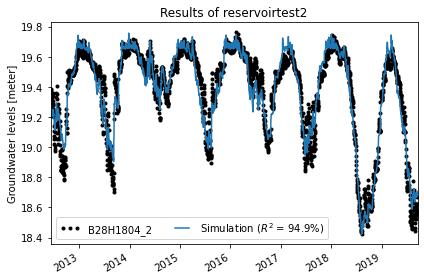

In [15]:
ml.plot();

### Tarso model has one additional parameter

In [16]:
mltarso = ps.Model(hobs, name='tarso', constant=False, noisemodel=False)
smtarso = ps.TarsoModel(prec, evap, hobs)
mltarso.add_stressmodel(smtarso)
mltarso.solve(noise=False)

INFO: Inferred frequency for time series B28H1804_2: freq=D
INFO: Inferred frequency for time series B28H1804_2: freq=D
INFO: Inferred frequency for time series RD Weerselo: freq=D
INFO: Inferred frequency for time series EV24 Twenthe: freq=D
INFO: Time Series RD Weerselo was extended to 2019-09-17 00:00:00 with the mean value of the time series.
INFO: Time Series EV24 Twenthe was extended to 2019-09-17 00:00:00 with the mean value of the time series.
INFO: There are observations between the simulation timesteps. Linear interpolation between simulated values is used.


Fit report tarso                   Fit Statistics
nfev    19                     EVP           97.03
nobs    2659                   R2             0.97
noise   False                  RMSE           0.05
tmin    2012-06-06 20:00:00    AIC       -15579.45
tmax    2019-09-17 20:00:00    BIC       -15538.25
freq    D                      Obj            3.77
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.         Yes

Parameters (7 optimized)
                optimal  stderr     initial  vary
recharge_A0  645.258700  ±1.14%  217.664114  True
recharge_a0  133.526758  ±1.44%   10.000000  True
recharge_d0   19.289462  ±0.08%   19.093000  True
recharge_A1  160.956787  ±4.34%  217.664114  True
recharge_a1  123.649980  ±3.09%   10.000000  True
recharge_d1   19.506787  ±0.02%   19.427000  True
recharge_f    -1.055187  ±1.00%   -1.000000  True


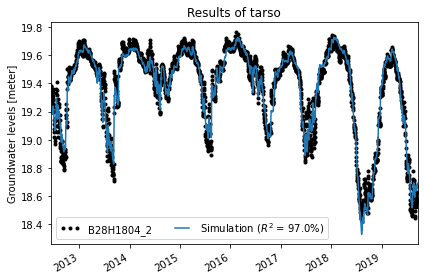

In [17]:
mltarso.plot();